# Binomial Option Pricing
By James Harvey \
James.Joseph.Harvey@gmail.com \
https://www.linkedin.com/in/james-harvey-76a3b1202/

In [51]:
import numpy as np
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
from labellines import labelLines
from scipy.stats import binom
from scipy.stats import norm

### Define Option Details 

In [52]:
interest = 0.04
numPeriods = 3
optionType = "Call"
timeToExpiration = 0.75
vol = 0.04
up = np.round(np.exp(vol * np.sqrt(timeToExpiration / numPeriods)), 4) # Define the size of an up movement in terms of implied volatility
down = 1/up
spot = 100
strike = 100
# Probability of an up movement by the assumption it is a risk-neutral world
p = ((1 + interest*(timeToExpiration/numPeriods)) - down) / (up - down)

## Create binomial tree for the underlying price of the option

In [53]:

def create_level(previousLevel, up, down):
    newLevel = []
    for i in previousLevel:
        newLevel.append(i * down)
    newLevel.append(previousLevel[-1]*up)
    return newLevel

def create_underlying_tree(spot, up, down, numPeriods):
    underlyingTree = [[spot]]
    count = 1
    while count <= numPeriods:
        underlyingTree.append(create_level(underlyingTree[-1], up, down))
        count = count + 1
    return underlyingTree

def plot_underlying_tree(underlyingTree):
    numPeriods = len(underlyingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)

    for i in range(numPeriods+1):
                value = underlyingTree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value

    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')
    plt.title('')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for i in range(len(x)- 1):
            plt.text((x[i] + x[i+1]) / 2, (v[i] + v[i+1]) / 2, f'{1 - abs(((i % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom')
    
        for xi, vi in zip(x, v):
            plt.text(xi, vi, f'{vi:.2f}', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

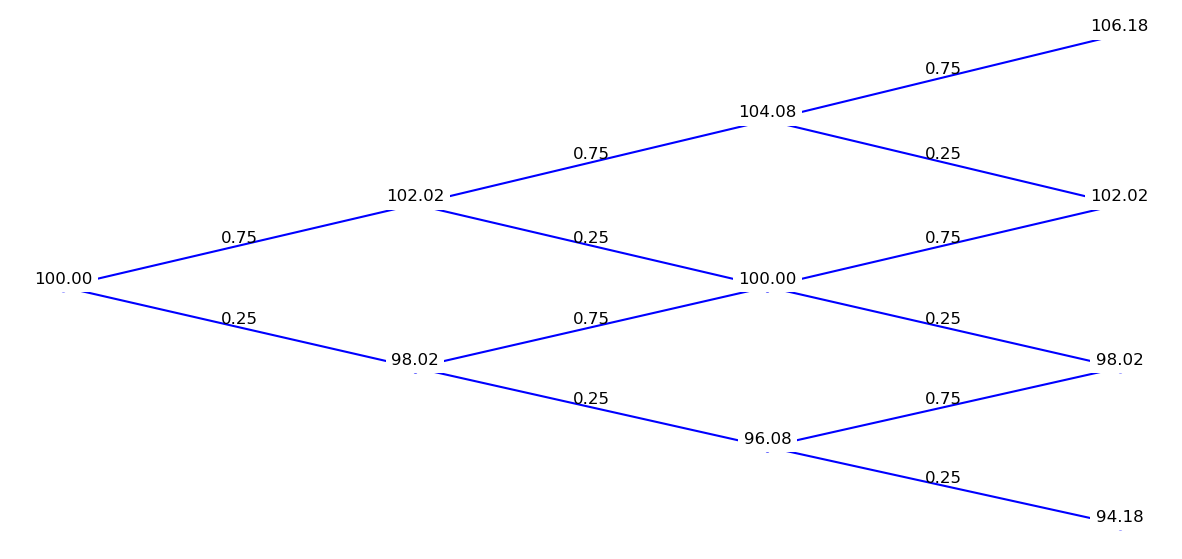

In [54]:
underlyingTree = create_underlying_tree(spot, up, down, numPeriods)
plot_underlying_tree(underlyingTree)

## Create binomial tree with the option value at any point
At expiration the option is worth exactly its intrinsic value.

S - Underlying Price \
X - Strike Price

For a call:\
&emsp; maximum(S - X, 0)

For a put:\
&emsp; maximum(X - S, 0)

By propagating the price of the option at exercise back through the tree the present value for the option can be calculated.

In [55]:
def create_option_value_level(previousLevel, p, interest, timeToExpiration, numPeriods, optionType="Call"):
    newLevel = []
    for i in range(len(previousLevel) - 1):
        newLevel.append(((1-p) * previousLevel[i] + p * previousLevel[i+1]) / (1+(interest*timeToExpiration/numPeriods)))
    return newLevel

def create_option_value_tree(underlyingTreeLastLevel, strike, p, interest, timeToExpiration, numPeriods, optionType="Call",):
    option_value_tree = []
    if optionType == "Call":
        currentLevel = [max(0, item - strike) for item in underlyingTreeLastLevel]
    elif optionType == "Put":
        currentLevel = [max(0, strike - item) for item in underlyingTreeLastLevel]
    while(len(currentLevel) > 0):
        option_value_tree.append(currentLevel)
        currentLevel = create_option_value_level(currentLevel, p, interest, timeToExpiration, numPeriods)
    option_value_tree.reverse()
    return option_value_tree

def plot_option_value_tree(underlyingTree, option_value_tree):
    numPeriods = len(underlyingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    option_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    for i in range(numPeriods+1):
                value = underlyingTree[i]
                option_value = option_value_tree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value
                option_mat[rows, cols] = option_value

    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')


    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        option_v = option_mat[x, y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for i in range(len(x)- 1):
            plt.text((x[i] + x[i+1]) / 2, (v[i] + v[i+1]) / 2, f'{1 - abs(((i % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom',)


        for xi, vi, ci in zip(x, v, option_v):
            plt.text(xi, vi, f'{vi:.2f}\n{ci:.2f}', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

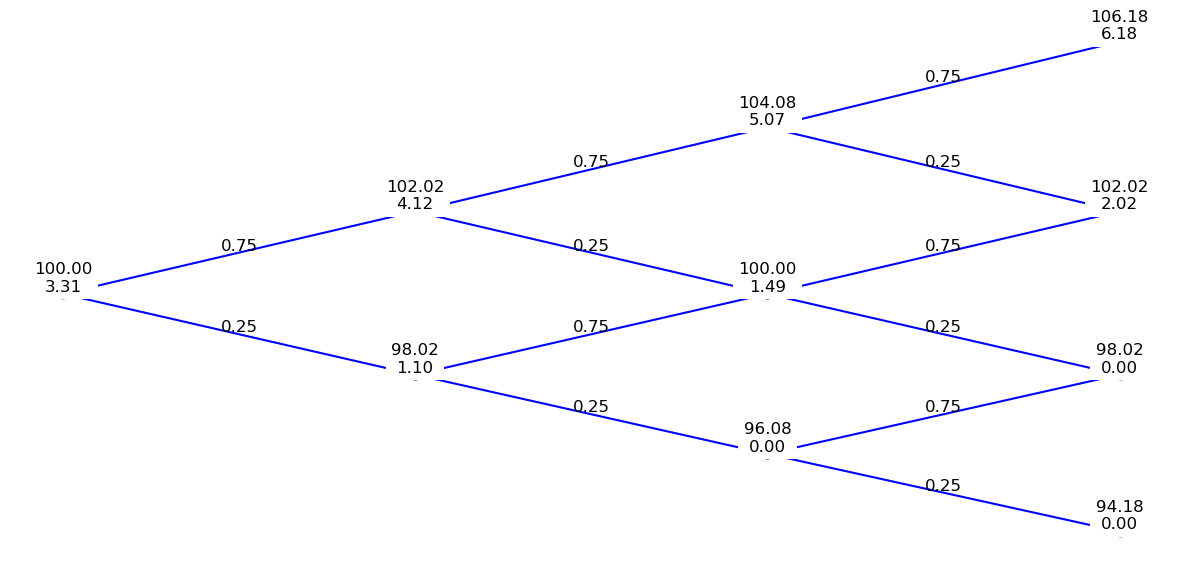

In [56]:
option_value_tree = create_option_value_tree(underlyingTree[-1], strike, p, interest, timeToExpiration, numPeriods, optionType)
plot_option_value_tree(underlyingTree, option_value_tree)

## Calculate the value of delta for each point in the binomial tree
The delta is the change in the option's value with respect to movement in the price of the underlying contract. We can express this as a fraction \
For a call:
&emsp; Δ = $\frac{C_{up} - C_{down}}{S_{up} - S_{down}}$

For a put:
&emsp; Δ = $\frac{P_{up} - P_{down}}{S_{up} - S_{down}}$

In [57]:
def create_delta_tree(underlyingTree, option_value_tree):
    delta_tree = []
    for i in range(1, len(underlyingTree)):
        priceTree = underlyingTree[i]
        optionTree = option_value_tree[i]
        currentLevel = []
        for j in range(i):
            currentLevel.append((optionTree[j+1] - optionTree[j]) / (priceTree[j+1] - priceTree[j])  * 100)
        delta_tree.append(currentLevel)
    return delta_tree

def plot_delta_tree(underlyingTree, option_value_tree, delta_tree):
    numPeriods = len(underlyingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    option_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    delta_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    for i in range(numPeriods+1):
                value = underlyingTree[i]
                option_value = option_value_tree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value
                option_mat[rows, cols] = option_value
                if i == numPeriods:
                    break
                delta_value = delta_tree[i]
                delta_mat[rows, cols] = delta_value
    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        option_v = option_mat[x, y].toarray()[0]
        delta_v = delta_mat[x,y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for j in range(len(x)- 1):
            plt.text((x[j] + x[j+1]) / 2, (v[j] + v[j+1]) / 2, f'{1 - abs(((j % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom',)

        for j in range(len(x)):
            if i == numPeriods - 1  and j % 2 == 0:
                plt.text(x[j], v[j], f'{option_v[j]:.2f}', fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))
            else:
                plt.text(x[j], v[j], f'{v[j]:.2f}\n{option_v[j]:.2f}\nΔ = {delta_v[j]:.0f}', fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))
        

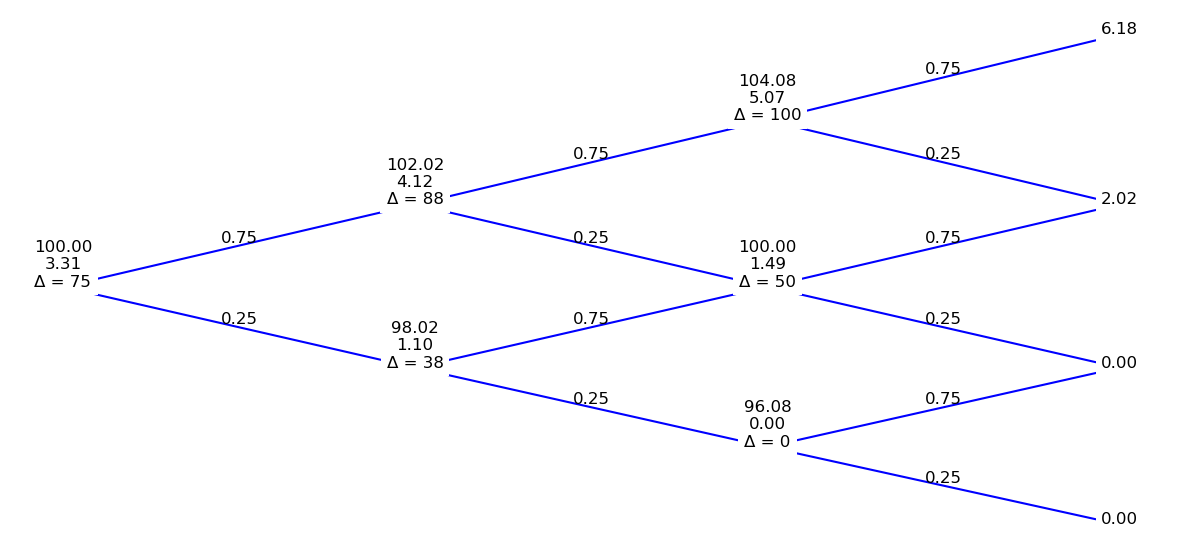

In [58]:

delta_tree = create_delta_tree(underlyingTree, option_value_tree)
plot_delta_tree(underlyingTree, option_value_tree, delta_tree)

## A function to plot a binomial tree with optional call and delta values

In [59]:
def plot_option_tree(underlyingTree, option_value_tree=None, delta_tree=None):
    numPeriods = len(underlyingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    option_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    delta_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    for i in range(numPeriods+1):
                value = underlyingTree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value
                if option_value_tree is not None:
                    option_value = option_value_tree[i]
                    option_mat[rows, cols] = option_value
                if delta_tree is None:
                    continue
                if i == numPeriods:
                    break
                delta_value = delta_tree[i]
                delta_mat[rows, cols] = delta_value
    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        option_v = option_mat[x, y].toarray()[0]
        delta_v = delta_mat[x,y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for j in range(len(x)- 1):
            plt.text((x[j] + x[j+1]) / 2, (v[j] + v[j+1]) / 2, f'{1 - abs(((j % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom',)

        for j in range(len(x)):
            string = f'{v[j]:.2f}'
            if option_value_tree is not None:
                    string += f'\n{option_v[j]:.2f}'
            if not (i == numPeriods - 1  and j % 2 == 0):
                if delta_tree is not None: 
                    string += f'\nΔ = {delta_v[j]:.0f}'
            plt.text(x[j], v[j], string, fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

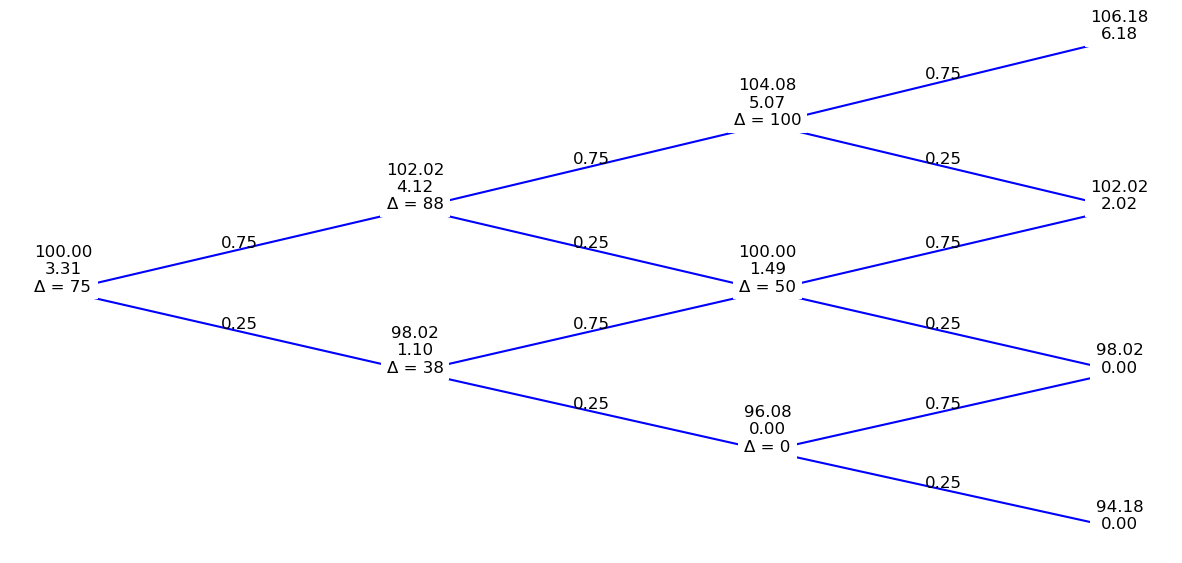

In [60]:
plot_option_tree(underlyingTree, delta_tree=delta_tree, option_value_tree=option_value_tree)

## Black-Scholes model for calculating an option's price

In [61]:
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)
print("Option Value:", round(BS_CALL(spot, strike, timeToExpiration, interest, vol), 2))

Option Value: 3.32


## Comparing the value obtained by the binomial option underlying method and Black-Scholes method for different time periods

In [62]:
values = []
maxPeriods = 250
for i in range(2, maxPeriods):
    dt = timeToExpiration / i
    vol = 0.04
    up = np.exp(vol * np.sqrt(dt))
    down = 1 / up
    underlyingTree = create_underlying_tree(spot, up, down, i)
    p = ((1 + interest*(timeToExpiration/i)) - down) / (up - down)
    option_value_tree = create_option_value_tree(underlyingTree[-1], strike, p, interest, timeToExpiration, i)
    values.append(option_value_tree[0][0])

bs_value = BS_CALL(spot, strike, timeToExpiration, interest, vol)

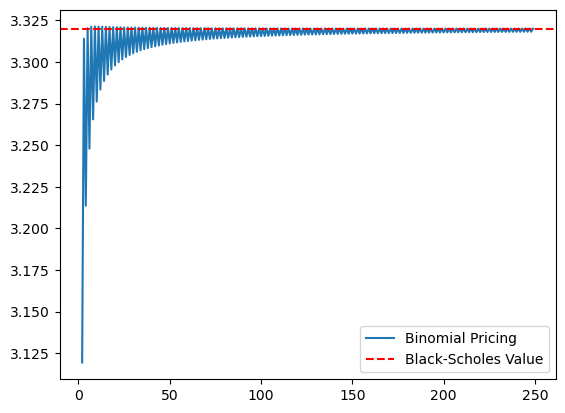

In [63]:
plt.plot(range(2,maxPeriods), values, label="Binomial Pricing")
plt.axhline(y=bs_value, color='r', linestyle='--', label="Black-Scholes Value")
plt.legend()
plt.show()

## Examples seen in Option Volatility and Pricing by Sheldon Natenberg. Chapter 19

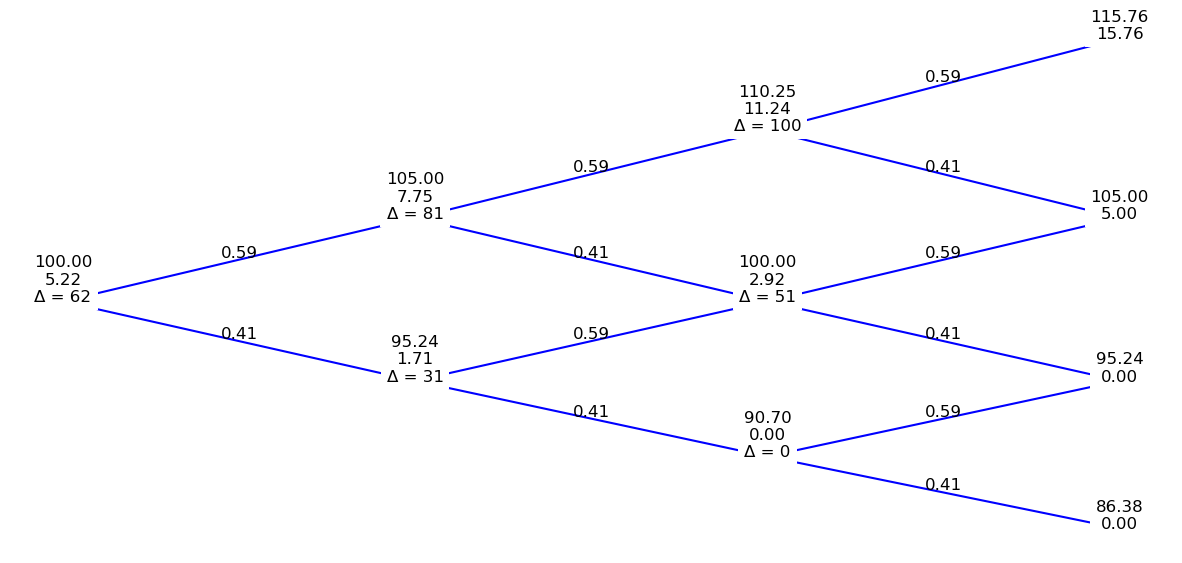

In [76]:
interest = 0.04
numPeriods = 3
optionType = "Call"
timeToExpiration = 0.75
vol = 0.04
up = 1.05
down = 1/up
spot = 100
strike = 100
p = ((1 + interest*(timeToExpiration/numPeriods)) - down) / (up - down)

underlyingTree = create_underlying_tree(spot, up, down, numPeriods)
option_value_tree = create_option_value_tree(underlyingTree[-1], strike, p, interest, timeToExpiration, numPeriods, optionType)
delta_tree = create_delta_tree(underlyingTree, option_value_tree)

plot_option_tree(underlyingTree, delta_tree=delta_tree, option_value_tree=option_value_tree)

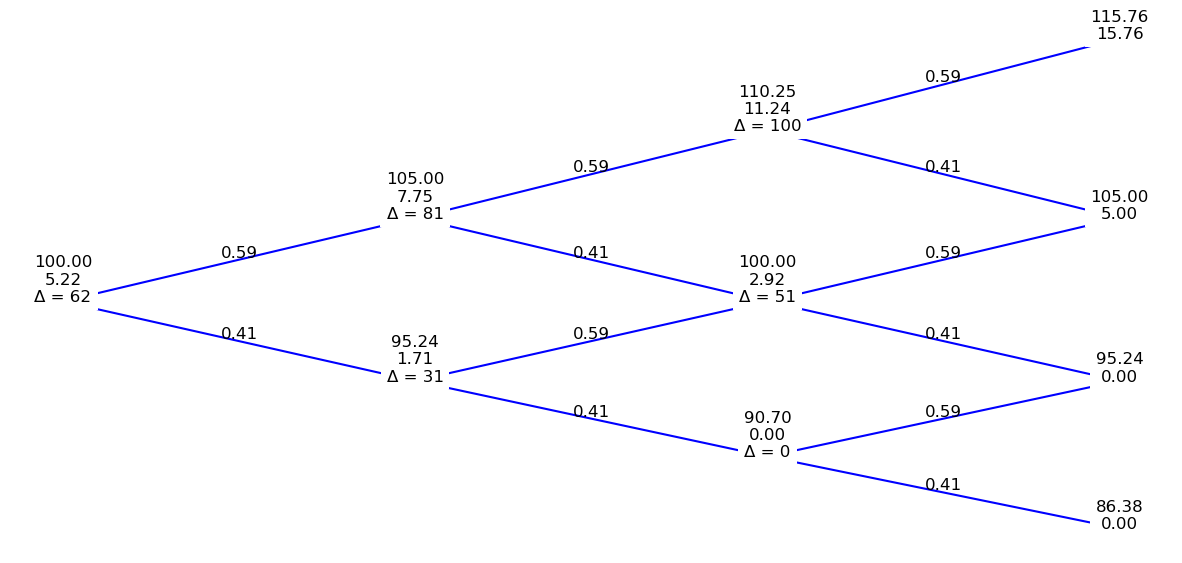

In [78]:
interest = 0.04
numPeriods = 3
optionType = "Call"
timeToExpiration = 0.75
vol = 0.04
up = 1.05
down = 1/up
spot = 100
strike = 100
p = ((1 + interest*(timeToExpiration/numPeriods)) - down) / (up - down)

underlyingTree = create_underlying_tree(spot, up, down, numPeriods)
option_value_tree = create_option_value_tree(underlyingTree[-1], strike, p, interest, timeToExpiration, numPeriods, optionType)
delta_tree = create_delta_tree(underlyingTree, option_value_tree)

plot_option_tree(underlyingTree, option_value_tree=option_value_tree)

## American Option Pricing
American option's can be exercised at anypoint whilst open. Therefore, to reflect this change, at each point in the binomial tree the maximum of the previous value calculated and the instrinsic value if exercised at that point is taken. 

In [66]:
def create_option_value_level_american(previousLevel, underlyingLevel, p, interest, timeToExpiration, numPeriods, optionType="Call", exerciseType = "European"):
    newLevel = []
    for i in range(len(previousLevel) - 1):
        optionValue = ((1-p) * previousLevel[i] + p * previousLevel[i+1]) / (1+(interest*timeToExpiration/numPeriods))
        if exerciseType == "American":
            if optionType == "Call":
                valueIfExercised = max(0, underlyingLevel[i] - strike) 
            elif optionType == "Put":
                valueIfExercised = max(0, strike - underlyingLevel[i])
            optionValue = max(optionValue, valueIfExercised)
        newLevel.append(optionValue)
    return newLevel

def create_option_value_tree_american(underlyingTree, strike, p, interest, timeToExpiration, numPeriods, optionType="Call", exerciseType = "European"):
    option_value_tree = []
    if optionType == "Call":
        currentLevel = [max(0, item - strike) for item in underlyingTree[-1]]
    elif optionType == "Put":
        currentLevel = [max(0, strike - item) for item in underlyingTree[-1]]
    counter = 0
    while(len(currentLevel) > 0):
        option_value_tree.append(currentLevel)
        counter += 1
        currentLevel = create_option_value_level_american(currentLevel, underlyingTree[numPeriods - counter],p, interest, timeToExpiration, numPeriods, optionType=optionType, exerciseType=exerciseType)
    option_value_tree.reverse()
    return option_value_tree

def plot_option_value_tree(underlyingTree, option_value_tree):
    numPeriods = len(underlyingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    option_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    for i in range(numPeriods+1):
                value = underlyingTree[i]
                option_value = option_value_tree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value
                option_mat[rows, cols] = option_value

    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        option_v = option_mat[x, y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for i in range(len(x)- 1):
            plt.text((x[i] + x[i+1]) / 2, (v[i] + v[i+1]) / 2, f'{1 - abs(((i % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom',)


        for xi, vi, ci in zip(x, v, option_v):
            plt.text(xi, vi, f'{vi:.2f}\n{ci:.2f}', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

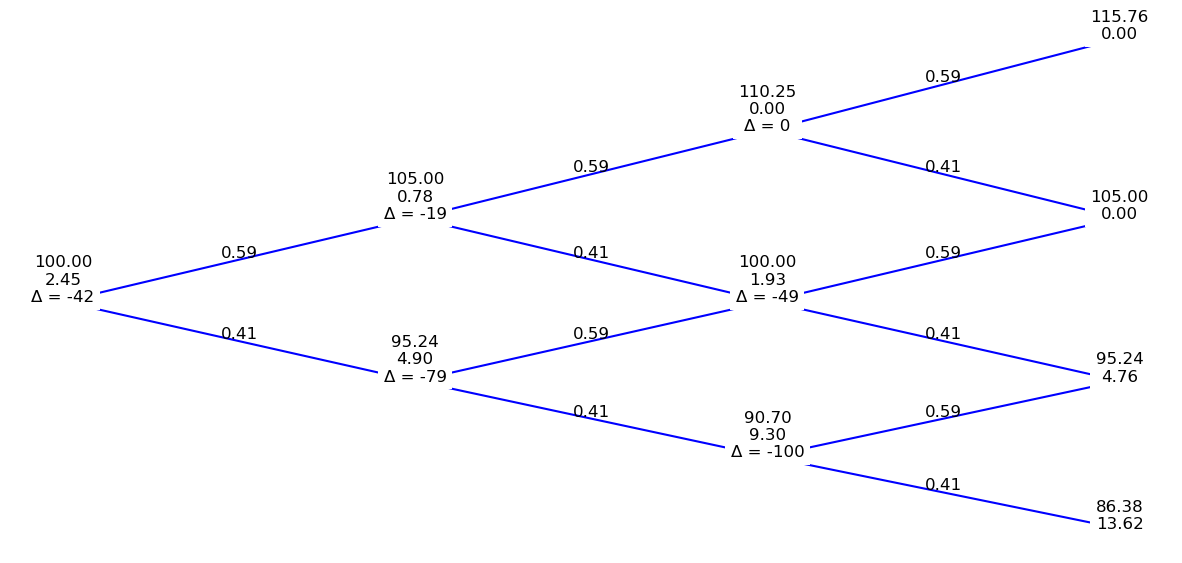

In [67]:
underlyingTree = create_underlying_tree(spot, up, down, numPeriods)
option_value_tree = create_option_value_tree_american(underlyingTree, strike, p, interest, timeToExpiration, numPeriods, optionType, exerciseType="American")
delta_tree = create_delta_tree(underlyingTree, option_value_tree)

plot_option_tree(underlyingTree, delta_tree=delta_tree, option_value_tree=option_value_tree)

## Improving Accuracy
Taking the averages of halfsteps

In [68]:
interest = 0.04
numPeriods = 10
optionType = "Call"
# optionType = "Put"
timeToExpiration = 0.25
dt = timeToExpiration / numPeriods
vol = 0.0976
up = np.exp(vol * np.sqrt(dt))
# up = 1.05
down = 1/up
spot = 100
strike = 100
p = ((1 + interest*(timeToExpiration/numPeriods)) - down) / (up - down)

values = []
averageValues = []
maxPeriods = 10
last = -1
periodRange = range(1, maxPeriods)
for i in periodRange:
    dt = timeToExpiration / i
    up = np.exp(vol * np.sqrt(dt))
    down = 1 / up
    underlyingTree = create_underlying_tree(spot, up, down, i)
    p = ((1 + interest*(timeToExpiration/i)) - down) / (up - down)
    option_value_tree = create_option_value_tree(underlyingTree[-1], strike, p, interest, timeToExpiration, i)
    values.append(option_value_tree[0][0])
    if last != -1:
        averageValues.append((last + option_value_tree[0][0]) / 2)
    last = option_value_tree[0][0]

bs_value = BS_CALL(spot, strike, timeToExpiration, interest, vol)

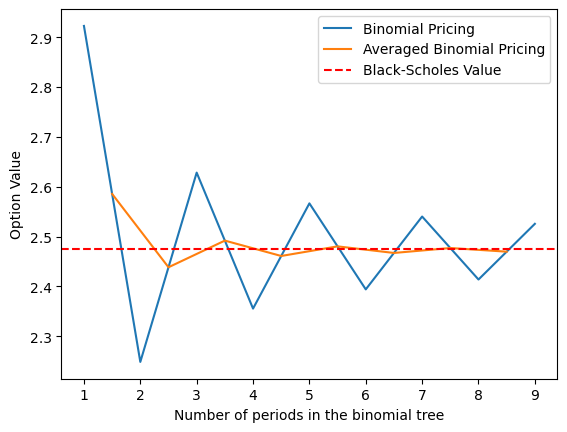

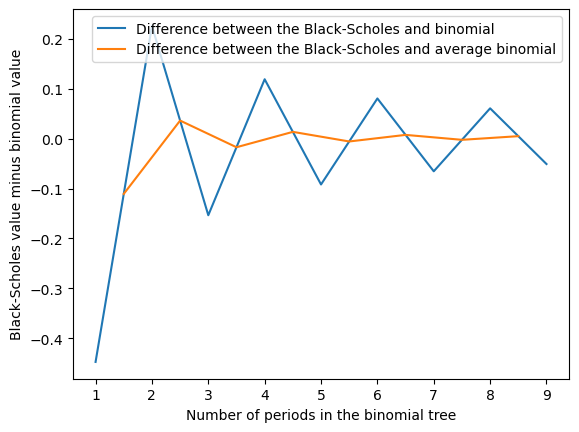

In [69]:
plt.plot(periodRange, values, label="Binomial Pricing")
plt.plot([item + 0.5 for item in periodRange][:-1], averageValues, label="Averaged Binomial Pricing")
plt.axhline(y=bs_value, color='r', linestyle='--', label="Black-Scholes Value")
plt.legend()
plt.xlabel('Number of periods in the binomial tree')
plt.ylabel('Option Value')
plt.show()

plt.plot(periodRange, [bs_value - item for item in values], label="Difference between the Black-Scholes and binomial")
plt.plot([item + 0.5 for item in periodRange][:-1], [bs_value - item for item in averageValues], label="Difference between the Black-Scholes and average binomial")
plt.title("")
plt.legend()
plt.xlabel('Number of periods in the binomial tree')
plt.ylabel('Black-Scholes value minus binomial value')
plt.show()

## Calculating the option's price using the binomial distribution

In [70]:
interest = 0.04
numPeriods = 100
optionType = "Call"
# optionType = "Put"
timeToExpiration = 1
dt = timeToExpiration / numPeriods
vol = 0.04
up = np.round(np.exp(vol * np.sqrt(dt)), 4)
# up = 1.05
down = 1/up
spot = 100
strike = 104
p = ((1 + interest*(timeToExpiration/numPeriods)) - down) / (up - down)


# Parameters
n = numPeriods
# Range of possible number of successes
x = np.arange(0, n+1)

# Probability mass function (PMF)
pmf = binom.pmf(x, n, p)
underlyingTree = create_underlying_tree(spot, up, down, numPeriods)
p = ((1 + interest*(timeToExpiration/numPeriods)) - down) / (up - down)
option_value_tree = create_option_value_tree(underlyingTree[-1], strike, p, interest, timeToExpiration, numPeriods)
total = 0
for prob, val in zip(pmf, option_value_tree[-1]):
    total += prob * val

print(f'{total:.2f}')

1.69


## Visualising the probability and the option's intrinsic value against the option's underlying price

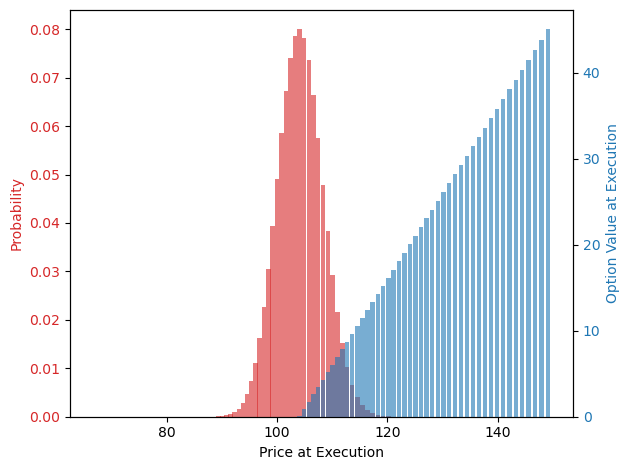

In [71]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Price at Execution')
ax1.set_ylabel('Probability', color=color)
ax1.bar(underlyingTree[-1], pmf, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Option Value at Execution', color=color)  # we already handled the x-label with ax1
ax2.bar(underlyingTree[-1], option_value_tree[-1], color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Multiplying the two distributions to obtain expected value from each underlying price at exercise

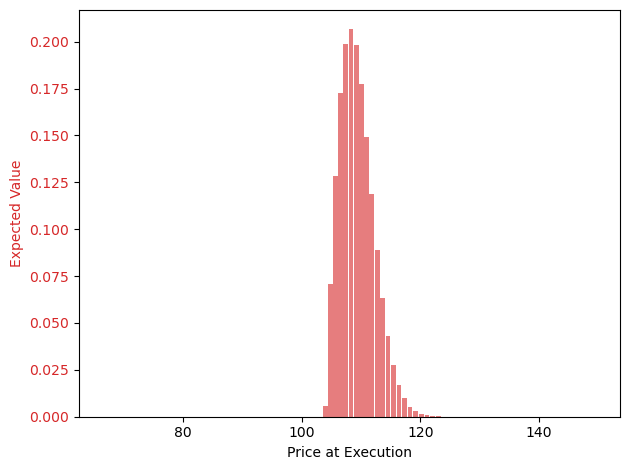

The area of the distribution is: 1.69


In [72]:
total = 0
resultList = []
for prob, val in zip(pmf, option_value_tree[-1]):
    resultList.append(prob*val)
    total += prob * val

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Price at Execution')
ax1.set_ylabel('Expected Value', color=color)
ax1.bar(underlyingTree[-1], resultList, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()

print("The area of the distribution is:", f'{total:.2f}')

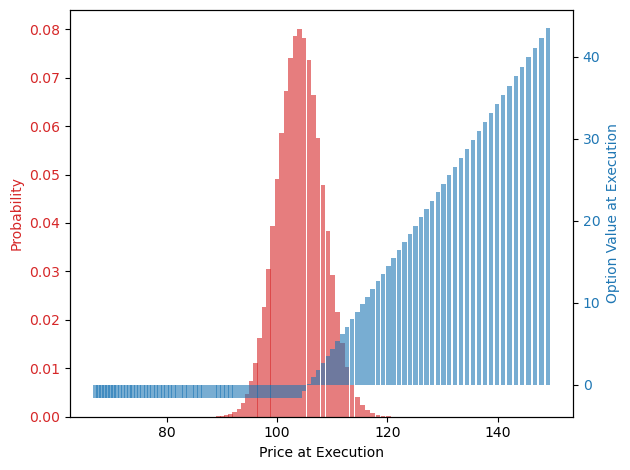

In [73]:
bs_value = BS_CALL(spot, strike, timeToExpiration, interest, vol)
profit_loss = [item - bs_value for item in option_value_tree[-1]]

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Price at Execution')
ax1.set_ylabel('Probability', color=color)
ax1.bar(underlyingTree[-1], pmf, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Option Value at Execution', color=color)  # we already handled the x-label with ax1
ax2.bar(underlyingTree[-1], profit_loss, color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

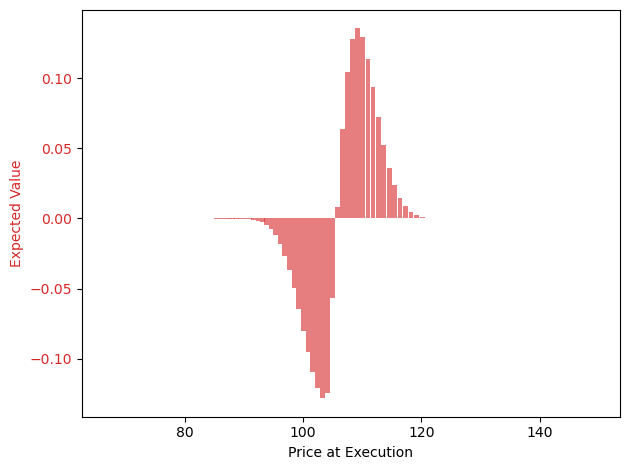

The area of the distribution is: 0.05


In [74]:
total = 0
resultList = []
for prob, val in zip(pmf, profit_loss):
    resultList.append(prob*val)
    total += prob * val

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Price at Execution')
ax1.set_ylabel('Expected Value', color=color)
ax1.bar(underlyingTree[-1], resultList, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()

print("The area of the distribution is:", f'{total:.2f}')